# 0.- Desciption

This notebook solves the sources updating problem while using the scanner to get the sources observations

In [1]:
# Module import
from IPython.display import Image
import sys
import quaternion

# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')


import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from agis import Agis
from agis import Calc_source
from agis_functions import *
from analytic_plots import *


# Ipython magics
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

FIG_FOLDER = './figures'


# 1.- **Initializing objects**

### 1.1 Create satellite

In [2]:
t_init = 0 
t_end =  t_init + 365*2
my_dt = 1/24/10 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)

### 1.2 Create source

In [3]:
sirio = Source("sirio", 101.28, -16.7161, 379.21, -546.05, -1223.14, -7.6)
vega = Source("vega", 279.2333, 38.78, 128.91, 201.03, 286.23, -13.9)
proxima = Source("proxima", 217.42, -62, 768.7, 3775.40, 769.33, 21.7)

In [4]:
sources = [sirio, vega, proxima]

### 1.3 Create scanner

In [5]:
scanner = Scanner(double_telescope=True) 

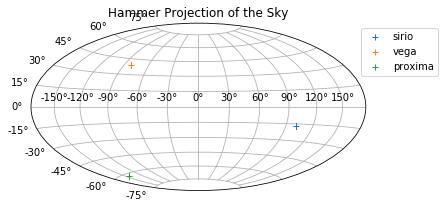

In [6]:
plot_sources_in_sky(sources)

# 2.- **Scan**
For the moment the scanner can only scan one source at a time

### 2.1 scan sirio

In [7]:
scanner.scan(gaia, sirio, ti=t_init, tf=t_end)
scanner.compute_angles_eta_zeta(gaia, sirio)  # necessary since its also clean mistaken observations
print('How many observation time?  {}'.format(len(scanner.obs_times)))
print('Error: ', scanner.scanner_error())
print('Mean zeta:', np.mean(scanner.zeta_scanned))

# Save the observed time in a calc source
calc_sirio = Calc_source(obs_times=scanner.obs_times.copy(), source=sirio)

How many observation time?  35
Error:  7.768196860180263e-14
Mean zeta: -0.0013355541122108063


### 2.2 scan vega

In [8]:
scanner.scan(gaia, vega, ti=t_init, tf=t_end)
scanner.compute_angles_eta_zeta(gaia, vega)  # necessary since its also clean mistaken observations
print('How many observation time?  {}'.format(len(scanner.obs_times)))
print('Error: ', scanner.scanner_error())
print('Mean zeta:', np.mean(scanner.zeta_scanned))

# Save the observed time in a calc source
calc_vega = Calc_source(obs_times=scanner.obs_times.copy(), source=vega)

How many observation time?  21
Error:  2.7711166694643907e-14
Mean zeta: 0.0007803839323628295


### 2.3 scan proxima

In [9]:
scanner.scan(gaia, proxima, ti=t_init, tf=t_end)
scanner.compute_angles_eta_zeta(gaia, proxima)  # necessary since its also clean mistaken observations
print('How many observation time?  {}'.format(len(scanner.obs_times)))
print('Error: ', scanner.scanner_error())
print('Mean zeta:', np.mean(scanner.zeta_scanned))

# Save the observed time in a calc source
calc_proxima = Calc_source(obs_times=scanner.obs_times.copy(), source=proxima)

How many observation time?  33
Error:  -1.1815464431768332e-14
Mean zeta: 0.0001845103009163592


# 3.- **Some Plots**

### 3.1 Field angles

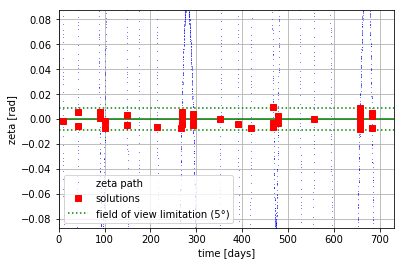

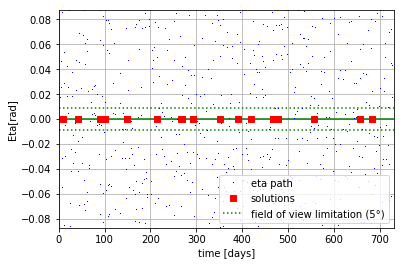

In [10]:
plot_field_angles(source=sirio, sat=gaia, obs_times=calc_sirio.obs_times, ti=t_init, tf=t_end, 
                  n=10000, limit=True, double_telescope=True);

Here eta is the angle in the scanning direction, or in other words the rotational axis that revolves the satellite is parallel to eta. Zeta is the orthogonal angle.  
The zeta component of the observation should be inside of the field of view (here 0.5°) and since we are minimizing the eta component, it shoulb as close to 0 as possible.

### 3.2 Star trajectory

Viewed in the ICRS coordinates system, the path of the star should be a strait line (no proper acceleration). Its movement is given by its proper motion:

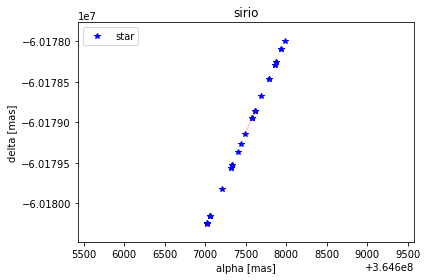

In [14]:
plot_star(source=sirio, satellite=gaia, obs_times=calc_sirio.obs_times);

As viewed by the satellite however we can also see a rotation given by the parallax of the star. (Remember that in this version (17/12/2018) gaia is turning around the sun in a circular motion. 

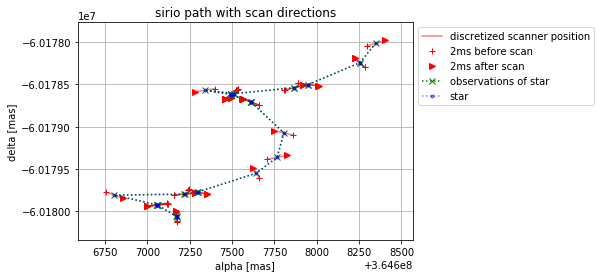

In [15]:
fig = plot_star_trajectory_with_scans(sat=gaia, source=sirio, obs_times=calc_sirio.obs_times, 
                                      num_ms_for_snapshot=2);
fig.savefig(FIG_FOLDER+'/tmp/source_path_with_scans.png')

The red "arrows" given the scanning direction a that point in time. We visualize where the satellite is pointing between plus or minus two milliseconds. We see the direction is changing, this is because we are following the nominal scanning law of Gaia.

# 4.- **Use Solver with scanned sources**

In [16]:
# group the calc sources into a unique list
calc_sources = [calc_sirio, calc_vega, calc_proxima]

In [17]:
# Add noise to the sources
noise = np.random.rand(5)*const.rad_per_mas*5
noise[2] += 20*const.rad_per_mas
for s in calc_sources:
    add_noise_to_calc_source(s, noise)

In [18]:
Solver = Agis(gaia, calc_sources, sources, updating='scanned source', double_telescope=True)

In [19]:
Solver.reset_iterations()
Solver.iterate(15)

Not resetting everything! Call again the solver instead


### 4.1 **See iterations**

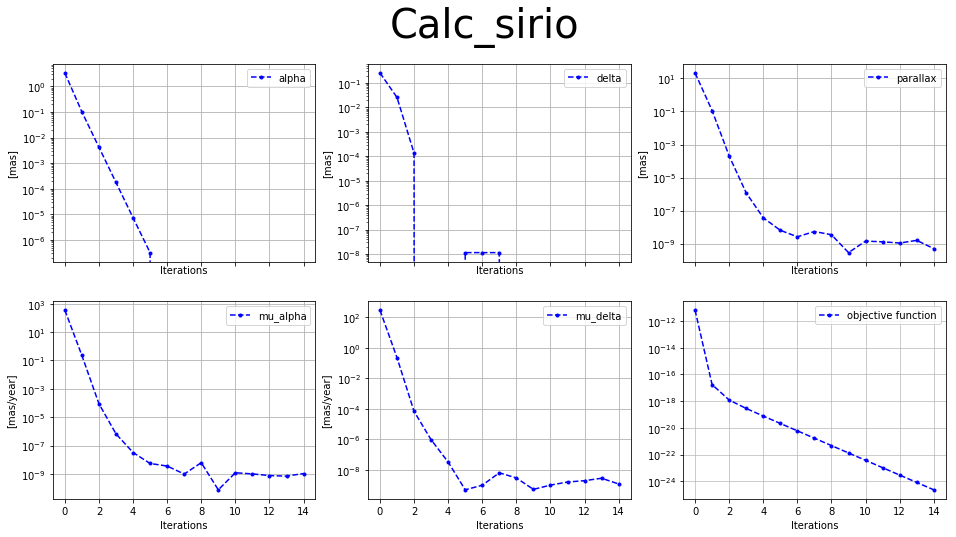

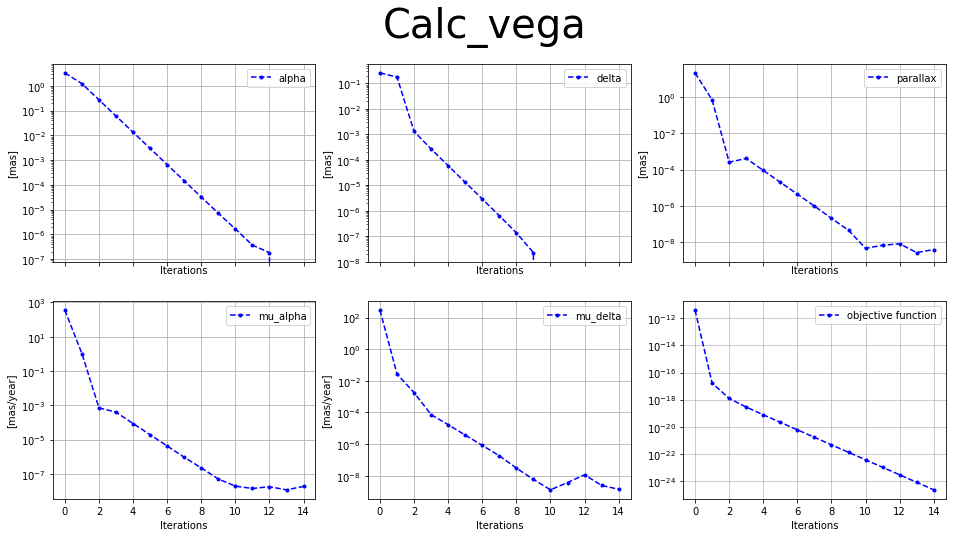

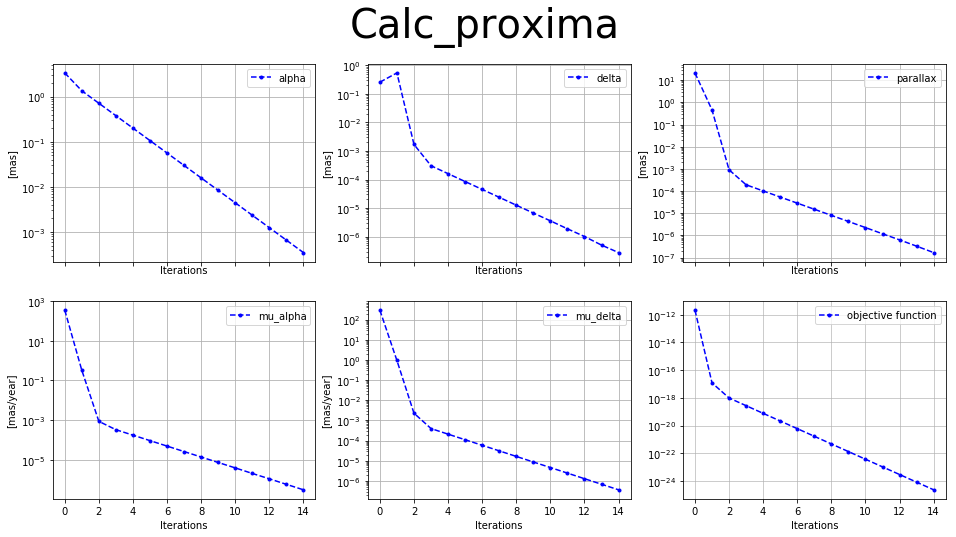

In [20]:
list_of_figs = plot_errors_VS_iterations_per_source(Solver)

### 5.- Conclusion
We hope you found this notebook useful and easy to use! If you have any remarks, do no thesitate to contact us and if not be sure to check out the others notebooks! 